# Lab environment

|LIBRARY|VERSION|
|--|--|
|nornir| 3.0.0|
|nornir-napalm|0.1.1|
|nornir-netmiko|0.1.1|
|nornir-utils|0.1.1|
|paramiko|2.7.2|
|requests|2.24.0|
|networkx|2.5|
|genie|20.10|
|pyats|20.10|
|matplotlib|3.3.3|

### Lab Scenario

![LAB](diagram.png)

# Gathering Data

## Collecting the devices operational status without a parser

In [1]:
from nornir import InitNornir
from nornir_netmiko.tasks import netmiko_send_command
from nornir_utils.plugins.functions import print_result

In [2]:
nr = InitNornir()

Listing the inventory's hosts

In [3]:
nr.inventory.hosts

{'SW1': Host: SW1,
 'SW2': Host: SW2,
 'SW3': Host: SW3,
 'SW4': Host: SW4,
 'SW5': Host: SW5,
 'SW6': Host: SW6,
 'SW7': Host: SW7}

Collecting CDP and VLAN data

In [4]:
getCDPNeighborsData = nr.run(
    name="get CDP neighbors data",
    task= netmiko_send_command,
    command_string = "show cdp neighbors detail"
)
getVLANData = nr.run(
    name="get VLAN data",
    task= netmiko_send_command,
    command_string = "show vlan"
)

Printing the results

In [5]:
print_result(getCDPNeighborsData)

get CDP neighbors data**********************************************************
* SW1 ** changed : False *******************************************************
vvvv get CDP neighbors data ** changed : False vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv INFO

-------------------------
Device ID: SW3.local
Entry address(es): 
  IP address: 172.16.30.93
Platform: Cisco ,  Capabilities: Router Switch IGMP 
Interface: GigabitEthernet0/1,  Port ID (outgoing port): GigabitEthernet0/2
Holdtime : 134 sec

Version :
Cisco IOS Software, vios_l2 Software (vios_l2-ADVENTERPRISEK9-M), Version 15.2(CML_NIGHTLY_20180619)FLO_DSGS7, EARLY DEPLOYMENT DEVELOPMENT BUILD, synced to  V152_6_0_81_E
Technical Support: http://www.cisco.com/techsupport
Copyright (c) 1986-2018 by Cisco Systems, Inc.
Compiled Tue 19-Jun-18 06:06 by mmen

advertisement version: 2
VTP Management Domain: ''
Native VLAN: 1
Duplex: full
Management address(es): 
  IP address: 172.16.30.93


Total cdp entries displayed : 1
^^^^ END get CDP neighbo

In [6]:
print_result(getVLANData)

get VLAN data*******************************************************************
* SW1 ** changed : False *******************************************************
vvvv get VLAN data ** changed : False vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv INFO


VLAN Name                             Status    Ports
---- -------------------------------- --------- -------------------------------
1    default                          active    Gi0/1
10   VLAN0010                         active    
1002 fddi-default                     act/unsup 
1003 token-ring-default               act/unsup 
1004 fddinet-default                  act/unsup 
1005 trnet-default                    act/unsup 

VLAN Type  SAID       MTU   Parent RingNo BridgeNo Stp  BrdgMode Trans1 Trans2
---- ----- ---------- ----- ------ ------ -------- ---- -------- ------ ------
1    enet  100001     1500  -      -      -        -    -        0      0   
10   enet  100010     1500  -      -      -        -    -        0      0   
1002

## Using Parsers

### Only CISCO

In [7]:
getCDPNeighbors_genie = nr.run(
    name="get CDP neighbors data",
    task= netmiko_send_command,
    command_string = "show cdp neighbors detail",
    use_genie = True
)

In [8]:
print_result(getCDPNeighbors_genie)

get CDP neighbors data**********************************************************
* SW1 ** changed : False *******************************************************
vvvv get CDP neighbors data ** changed : False vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv INFO
{ 'index': { 1: { 'advertisement_ver': 2,
                  'capabilities': 'Router Switch IGMP',
                  'device_id': 'SW3.local',
                  'duplex_mode': 'full',
                  'entry_addresses': {'172.16.30.93': {}},
                  'hold_time': 151,
                  'local_interface': 'GigabitEthernet0/1',
                  'management_addresses': {'172.16.30.93': {}},
                  'native_vlan': '1',
                  'platform': 'Cisco ',
                  'port_id': 'GigabitEthernet0/2',
                  'software_version': 'Cisco IOS Software, vios_l2 Software '
                                      '(vios_l2-ADVENTERPRISEK9-M), Version '
                                      '15.2(CML_NIGHTLY_20180619)F

### Creating custom Nornir Tasks

In [9]:
from nornir.core.task import Task, Result

In [11]:
def CustomTask(task: Task , variable) -> Result:
    return Result(
        host= task.host,
        result = f"Hostname : {task.host}\nPlatform: {task.host.platform}\nCustom variable: {variable}"
    )

In [12]:
customTaskResult = nr.run(
    name="Custom Task",
    task= CustomTask,
    variable = "This is a Custom Var"
)
print_result(customTaskResult)

Custom Task*********************************************************************
* SW1 ** changed : False *******************************************************
vvvv Custom Task ** changed : False vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv INFO
Hostname : SW1
Platform: ios
Custom variable: This is a Custom Var
^^^^ END Custom Task ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
* SW2 ** changed : False *******************************************************
vvvv Custom Task ** changed : False vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv INFO
Hostname : SW2
Platform: ios
Custom variable: This is a Custom Var
^^^^ END Custom Task ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
* SW3 ** changed : False *******************************************************
vvvv Custom Task ** changed : False vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv INFO
Hostname : SW3
Platform: ios
Custom variable: This is a Custom Var
^^^^ END Custom Task ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

### Using Genie Parsers

Adding additional libraries:

[ShowVlan](https://github.com/CiscoTestAutomation/genieparser/blob/master/src/genie/libs/parser/iosxe/show_vlan.py)

[ShowCdpNeighborsDetail](https://github.com/CiscoTestAutomation/genieparser/blob/master/src/genie/libs/parser/iosxe/show_cdp.py)


In [13]:
from nornir_netmiko.connections import CONNECTION_NAME
from genie.libs.parser.iosxe.show_cdp import ShowCdpNeighborsDetail
from genie.libs.parser.iosxe.show_vlan import ShowVlan
from unittest.mock import Mock

In [14]:
def customCDPParser(task: Task) -> Result :
    if(task.host.platform == 'ios'):
        net_connect = task.host.get_connection(CONNECTION_NAME, task.nornir.config)
        result = net_connect.send_command("show cdp neighbors detail")
        parser = ShowCdpNeighborsDetail(Mock())
        result = parser.cli(result)
    return Result(
        host= task.host,
        result= result
    )

def customVlanParser(task: Task) -> Result :
    if(task.host.platform == 'ios'):
        net_connect = task.host.get_connection(CONNECTION_NAME, task.nornir.config)
        result = net_connect.send_command("show vlan")
        parser = ShowVlan(Mock())
        result = parser.cli(result)
    return Result(
        host= task.host,
        result= result
    )

In [15]:
customCDPResult = nr.run(
    name="Get CDP Neighbors",
    task= customCDPParser
)
customVlanResult = nr.run(
    name="Get Vlans",
    task= customVlanParser
)

In [16]:
print_result(customCDPResult)

Get CDP Neighbors***************************************************************
* SW1 ** changed : False *******************************************************
vvvv Get CDP Neighbors ** changed : False vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv INFO
{ 'index': { 1: { 'advertisement_ver': 2,
                  'capabilities': 'Router Switch IGMP',
                  'device_id': 'SW3.local',
                  'duplex_mode': 'full',
                  'entry_addresses': {'172.16.30.93': {}},
                  'hold_time': 151,
                  'local_interface': 'GigabitEthernet0/1',
                  'management_addresses': {'172.16.30.93': {}},
                  'native_vlan': '1',
                  'platform': 'Cisco ',
                  'port_id': 'GigabitEthernet0/2',
                  'software_version': 'Cisco IOS Software, vios_l2 Software '
                                      '(vios_l2-ADVENTERPRISEK9-M), Version '
                                      '15.2(CML_NIGHTLY_20180619)F

In [17]:
print_result(customVlanResult)

Get Vlans***********************************************************************
* SW1 ** changed : False *******************************************************
vvvv Get Vlans ** changed : False vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv INFO
{ 'vlans': { '1': { 'interfaces': ['GigabitEthernet0/1'],
                    'mtu': 1500,
                    'name': 'default',
                    'said': 100001,
                    'shutdown': False,
                    'state': 'active',
                    'trans1': 0,
                    'trans2': 0,
                    'type': 'enet',
                    'vlan_id': '1'},
             '10': { 'mtu': 1500,
                     'name': 'VLAN0010',
                     'said': 100010,
                     'shutdown': False,
                     'state': 'active',
                     'trans1': 0,
                     'trans2': 0,
                     'type': 'enet',
                     'vlan_id': '10'},
             '1002': { 'mtu': 150

## Creating a Graph with NetworkX

### Importing Libraries

In [18]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout

### Creating Nodes

In [19]:
nodes = list(customCDPResult.keys())
nodes

['SW1', 'SW2', 'SW3', 'SW4', 'SW5', 'SW6', 'SW7']

In [20]:
G = nx.MultiGraph()
G.add_nodes_from(nodes)

In [21]:
G.nodes

NodeView(('SW1', 'SW2', 'SW3', 'SW4', 'SW5', 'SW6', 'SW7'))

## Accessing and adding data to nodes

In [22]:
G.nodes['SW1']

{}

In [23]:
G.nodes['SW1']['Custom_Data'] = "Some Data"
G.nodes['SW1']

{'Custom_Data': 'Some Data'}

In [24]:
del G.nodes['SW1']['Custom_Data']
G.nodes['SW1']

{}

In [25]:
G.nodes['SW1']

{}

## Creating a Vlan Database on the Nodes

In [26]:
customVlanResult['SW6'].result

{'vlans': {'1': {'vlan_id': '1',
   'name': 'default',
   'shutdown': False,
   'state': 'active',
   'interfaces': ['GigabitEthernet0/1'],
   'type': 'enet',
   'said': 100001,
   'mtu': 1500,
   'trans1': 0,
   'trans2': 0},
  '10': {'vlan_id': '10',
   'name': 'VLAN0010',
   'shutdown': False,
   'state': 'active',
   'type': 'enet',
   'said': 100010,
   'mtu': 1500,
   'trans1': 0,
   'trans2': 0},
  '1002': {'vlan_id': '1002',
   'name': 'fddi-default',
   'shutdown': False,
   'state': 'unsupport',
   'type': 'fddi',
   'said': 101002,
   'mtu': 1500,
   'trans1': 0,
   'trans2': 0},
  '1003': {'vlan_id': '1003',
   'name': 'token-ring-default',
   'shutdown': False,
   'state': 'unsupport',
   'type': 'tr',
   'said': 101003,
   'mtu': 1500,
   'trans1': 0,
   'trans2': 0},
  '1004': {'vlan_id': '1004',
   'name': 'fddinet-default',
   'shutdown': False,
   'state': 'unsupport',
   'type': 'fdnet',
   'said': 101004,
   'mtu': 1500,
   'stp': 'ieee',
   'trans1': 0,
   'trans2'

In [27]:
for node in G.nodes:
    node_vlanDB = []
    for vlan in customVlanResult[node].result['vlans']:
        vlan_data = customVlanResult[node].result['vlans'][vlan]
        if(vlan_data['type'] == 'enet'):
            node_vlanDB.append(vlan)
    G.nodes[node]['vlans'] = node_vlanDB

In [28]:
G.nodes.data()

NodeDataView({'SW1': {'vlans': ['1', '10']}, 'SW2': {'vlans': ['1', '10']}, 'SW3': {'vlans': ['1', '10']}, 'SW4': {'vlans': ['1']}, 'SW5': {'vlans': ['1', '10', '20']}, 'SW6': {'vlans': ['1', '10']}, 'SW7': {'vlans': ['1', '20']}})

## Connecting the Nodes

### Creating edges

In [29]:
G.add_edge('SW1','SW2')

0

In [30]:
G.edges

MultiEdgeView([('SW1', 'SW2', 0)])

In [31]:
G.add_edge('SW1','SW2' , data="Some Data")

1

In [32]:
G.edges

MultiEdgeView([('SW1', 'SW2', 0), ('SW1', 'SW2', 1)])

In [33]:
G.edges[(('SW1', 'SW2', 0))]

{}

In [34]:
G.edges[(('SW1', 'SW2', 1))]

{'data': 'Some Data'}

In [35]:
G.edges[(('SW2', 'SW1', 1))]

{'data': 'Some Data'}

In [36]:
G.get_edge_data('SW1','SW2')

{0: {}, 1: {'data': 'Some Data'}}

In [37]:
G.clear_edges()

In [38]:
customCDPResult['SW4'].result

{'total_entries_displayed': 2,
 'index': {1: {'device_id': 'SW5.local',
   'duplex_mode': 'full',
   'vtp_management_domain': ' ',
   'native_vlan': '1',
   'management_addresses': {'172.16.30.95': {}},
   'entry_addresses': {'172.16.30.95': {}},
   'capabilities': 'Router Switch IGMP',
   'platform': 'Cisco ',
   'port_id': 'GigabitEthernet0/1',
   'local_interface': 'GigabitEthernet0/2',
   'hold_time': 134,
   'software_version': 'Cisco IOS Software, vios_l2 Software (vios_l2-ADVENTERPRISEK9-M), Version 15.2(CML_NIGHTLY_20180619)FLO_DSGS7, EARLY DEPLOYMENT DEVELOPMENT BUILD, synced to  V152_6_0_81_E\nTechnical Support: http://www.cisco.com/techsupport\nCopyright (c) 1986-2018 by Cisco Systems, Inc.\nCompiled Tue 19-Jun-18 06:06 by mmen',
   'advertisement_ver': 2},
  2: {'device_id': 'SW3.local',
   'duplex_mode': 'full',
   'vtp_management_domain': ' ',
   'native_vlan': '1',
   'management_addresses': {'172.16.30.93': {}},
   'entry_addresses': {'172.16.30.93': {}},
   'capabiliti

In [39]:
customCDPResult['SW4'].result['index']

{1: {'device_id': 'SW5.local',
  'duplex_mode': 'full',
  'vtp_management_domain': ' ',
  'native_vlan': '1',
  'management_addresses': {'172.16.30.95': {}},
  'entry_addresses': {'172.16.30.95': {}},
  'capabilities': 'Router Switch IGMP',
  'platform': 'Cisco ',
  'port_id': 'GigabitEthernet0/1',
  'local_interface': 'GigabitEthernet0/2',
  'hold_time': 134,
  'software_version': 'Cisco IOS Software, vios_l2 Software (vios_l2-ADVENTERPRISEK9-M), Version 15.2(CML_NIGHTLY_20180619)FLO_DSGS7, EARLY DEPLOYMENT DEVELOPMENT BUILD, synced to  V152_6_0_81_E\nTechnical Support: http://www.cisco.com/techsupport\nCopyright (c) 1986-2018 by Cisco Systems, Inc.\nCompiled Tue 19-Jun-18 06:06 by mmen',
  'advertisement_ver': 2},
 2: {'device_id': 'SW3.local',
  'duplex_mode': 'full',
  'vtp_management_domain': ' ',
  'native_vlan': '1',
  'management_addresses': {'172.16.30.93': {}},
  'entry_addresses': {'172.16.30.93': {}},
  'capabilities': 'Router Switch IGMP',
  'platform': 'Cisco ',
  'port_i

In [40]:
customCDPResult['SW4'].result['index'][1]

{'device_id': 'SW5.local',
 'duplex_mode': 'full',
 'vtp_management_domain': ' ',
 'native_vlan': '1',
 'management_addresses': {'172.16.30.95': {}},
 'entry_addresses': {'172.16.30.95': {}},
 'capabilities': 'Router Switch IGMP',
 'platform': 'Cisco ',
 'port_id': 'GigabitEthernet0/1',
 'local_interface': 'GigabitEthernet0/2',
 'hold_time': 134,
 'software_version': 'Cisco IOS Software, vios_l2 Software (vios_l2-ADVENTERPRISEK9-M), Version 15.2(CML_NIGHTLY_20180619)FLO_DSGS7, EARLY DEPLOYMENT DEVELOPMENT BUILD, synced to  V152_6_0_81_E\nTechnical Support: http://www.cisco.com/techsupport\nCopyright (c) 1986-2018 by Cisco Systems, Inc.\nCompiled Tue 19-Jun-18 06:06 by mmen',
 'advertisement_ver': 2}

In [41]:
customCDPResult['SW5'].result['index'][3]

{'device_id': 'SW4.local',
 'duplex_mode': 'full',
 'vtp_management_domain': ' ',
 'native_vlan': '1',
 'management_addresses': {'172.16.30.94': {}},
 'entry_addresses': {'172.16.30.94': {}},
 'capabilities': 'Router Switch IGMP',
 'platform': 'Cisco ',
 'port_id': 'GigabitEthernet0/2',
 'local_interface': 'GigabitEthernet0/1',
 'hold_time': 130,
 'software_version': 'Cisco IOS Software, vios_l2 Software (vios_l2-ADVENTERPRISEK9-M), Version 15.2(CML_NIGHTLY_20180619)FLO_DSGS7, EARLY DEPLOYMENT DEVELOPMENT BUILD, synced to  V152_6_0_81_E\nTechnical Support: http://www.cisco.com/techsupport\nCopyright (c) 1986-2018 by Cisco Systems, Inc.\nCompiled Tue 19-Jun-18 06:06 by mmen',
 'advertisement_ver': 2}

In [42]:
for node in G.nodes:
    neighbors = customCDPResult[node].result['index']
    for nei_ix in neighbors:
        neighbor = customCDPResult[node].result['index'][nei_ix]
        data = {}
        data[node] = {
            'local_interface' : neighbor['local_interface'],
            'remote_interface': neighbor['port_id'],
            'remote_device' : neighbor['device_id'].split(".")[0],
        }
        data[neighbor['device_id'].split(".")[0]] = {
            'local_interface' : neighbor['port_id'],
            'remote_interface': neighbor['local_interface'],
            'remote_device' : node,
        }
        if(G.has_edge(node , neighbor['device_id'].split(".")[0] )):
            nodes_data = G.get_edge_data(node , neighbor['device_id'].split(".")[0])
            mapped = False
            for data in nodes_data:
                edge_data = nodes_data[data]['data']
                if(edge_data[node]['local_interface'] == neighbor['local_interface']):
                    mapped = True
            if(not mapped):
                G.add_edge(node, neighbor['device_id'].split(".")[0] , data=data )
        else:
            G.add_edge(node, neighbor['device_id'].split(".")[0] , data=data )

In [43]:
G.edges()

MultiEdgeDataView([('SW1', 'SW3'), ('SW2', 'SW3'), ('SW3', 'SW4'), ('SW4', 'SW5'), ('SW5', 'SW7'), ('SW5', 'SW6')])

In [44]:
G.edges.data()

MultiEdgeDataView([('SW1', 'SW3', {'data': {'SW1': {'local_interface': 'GigabitEthernet0/1', 'remote_interface': 'GigabitEthernet0/2', 'remote_device': 'SW3'}, 'SW3': {'local_interface': 'GigabitEthernet0/2', 'remote_interface': 'GigabitEthernet0/1', 'remote_device': 'SW1'}}}), ('SW2', 'SW3', {'data': {'SW2': {'local_interface': 'GigabitEthernet0/1', 'remote_interface': 'GigabitEthernet0/1', 'remote_device': 'SW3'}, 'SW3': {'local_interface': 'GigabitEthernet0/1', 'remote_interface': 'GigabitEthernet0/1', 'remote_device': 'SW2'}}}), ('SW3', 'SW4', {'data': {'SW3': {'local_interface': 'GigabitEthernet0/3', 'remote_interface': 'GigabitEthernet0/1', 'remote_device': 'SW4'}, 'SW4': {'local_interface': 'GigabitEthernet0/1', 'remote_interface': 'GigabitEthernet0/3', 'remote_device': 'SW3'}}}), ('SW4', 'SW5', {'data': {'SW4': {'local_interface': 'GigabitEthernet0/2', 'remote_interface': 'GigabitEthernet0/1', 'remote_device': 'SW5'}, 'SW5': {'local_interface': 'GigabitEthernet0/1', 'remote_int

In [45]:
G.edges[('SW1', 'SW3',0)]['data']['SW1']

{'local_interface': 'GigabitEthernet0/1',
 'remote_interface': 'GigabitEthernet0/2',
 'remote_device': 'SW3'}

In [46]:
G.edges[('SW1', 'SW3',0)]['data']['SW3']

{'local_interface': 'GigabitEthernet0/2',
 'remote_interface': 'GigabitEthernet0/1',
 'remote_device': 'SW1'}

## Creating a subgraph

In [47]:
vlan10Nodes = []
for node in G.nodes:
    if '10' in G.nodes[node]['vlans']:
        vlan10Nodes.append(node)

In [48]:
vlan10Nodes

['SW1', 'SW2', 'SW3', 'SW5', 'SW6']

In [49]:
vlan10Graph = nx.subgraph(G , vlan10Nodes)

In [50]:
vlan10Graph.nodes

NodeView(('SW1', 'SW2', 'SW3', 'SW5', 'SW6'))

In [51]:
vlan10Graph.edges

MultiEdgeView([('SW1', 'SW3', 0), ('SW2', 'SW3', 0), ('SW5', 'SW6', 0)])

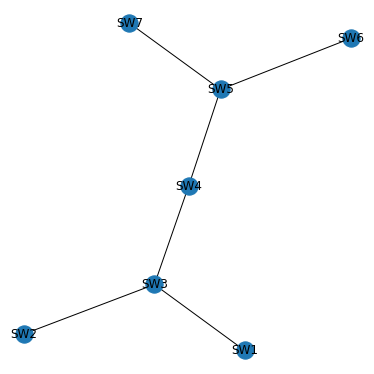

In [52]:
plt.figure(figsize=(5, 5))
nx.draw(G, with_labels=True)

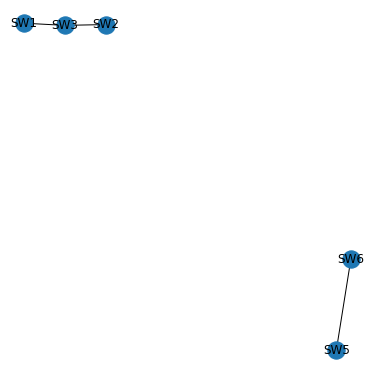

In [53]:
plt.figure(figsize=(5, 5))
nx.draw(vlan10Graph, with_labels=True)

In [54]:
list(nx.connected_components(vlan10Graph))

[{'SW1', 'SW2', 'SW3'}, {'SW5', 'SW6'}]

In [55]:
len(list(nx.connected_components(vlan10Graph)))

2

In [56]:
list(nx.all_simple_paths(G, source='SW6', target='SW2'))

[['SW6', 'SW5', 'SW4', 'SW3', 'SW2']]

In [57]:
for path in nx.all_simple_paths(G, source='SW6', target='SW2'):
    for node in path:
        if( not vlan10Graph.has_node(node)):
            print(f"Node {node} without VLAN configuration")

Node SW4 without VLAN configuration


## Pusshing data to NetBox

### Creating device

In [58]:
import warnings
warnings.filterwarnings('ignore')
import requests

In [59]:
api_token = "e0843675e1ff3f1d316a32edab1537e7a63364f4"
headers = {
        'accept': 'application/json',
        'Authorization': f"Token {api_token}",
    }

url = 'https://192.168.0.7/api'
endpoint = '/dcim/platforms/'
URI = f"{url}{endpoint}"
platform_params = {
        'name': 'ios',
}
r = requests.get(URI, headers=headers, params=platform_params, verify=False)
platform_response = r.json()

In [60]:
platform_response

{'count': 1,
 'next': None,
 'previous': None,
 'results': [{'id': 2,
   'url': 'https://192.168.0.7/api/dcim/platforms/2/',
   'name': 'ios',
   'slug': 'ios',
   'manufacturer': {'id': 3,
    'url': 'https://192.168.0.7/api/dcim/manufacturers/3/',
    'name': 'Cisco',
    'slug': 'cisco'},
   'napalm_driver': '',
   'napalm_args': None,
   'description': '',
   'device_count': None,
   'virtualmachine_count': None}]}

In [61]:
def CreateDevice(device_name, device_type , device_role , platform , site ):
    api_token = "e0843675e1ff3f1d316a32edab1537e7a63364f4"
    headers = {
        'accept': 'application/json',
        'Authorization': f"Token {api_token}",
    }
    
    url = 'https://192.168.0.7/api'
    endpoint = '/dcim/platforms/'
    URI = f"{url}{endpoint}"
    platform_params = {
        'name': platform,
    }
    r = requests.get(URI, headers=headers, params=platform_params, verify=False)
    platform_response = r.json()
    platform_id = platform_response['results'][0]['id']
    
    endpoint = '/dcim/sites/'
    URI = f"{url}{endpoint}"
    sites_params = {
        'name': site,
    }
    r = requests.get(URI, headers=headers, params=sites_params, verify=False)
    site_response = r.json()
    site_id = site_response['results'][0]['id']
    
    endpoint = '/dcim/device-roles/'
    URI = f"{url}{endpoint}"
    role_params = {
        'name': device_role,
    }
    r = requests.get(URI, headers=headers, params=role_params, verify=False)
    role_response = r.json()
    role_id = role_response['results'][0]['id']
    
    endpoint = '/dcim/device-types/'
    URI = f"{url}{endpoint}"
    type_params = {
        'model': device_type,
    }
    r = requests.get(URI, headers=headers, params=type_params, verify=False)
    type_response = r.json()
    type_id = type_response['results'][0]['id']
    
    endpoint = '/dcim/devices/'
    URI = f"{url}{endpoint}"
    device_payload = {
        "name": device_name,
        "device_type": type_id,
        "device_role": role_id,
        "platform":  platform_id,
        "site": site_id
    }
    r = requests.post(URI, headers=headers, json=device_payload, verify=False)
    return r.status_code

In [62]:
for node in G.nodes:
    device_type = "IOSv"
    device_role = "DC"
    platform =  "ios"
    site = 'DataCenter'
    CreateDevice(node,  device_type , device_role , platform , site )

## Creating connections

In [64]:
def connectDevices(localDevice , localInterface , remoteDevice, remoteInterface):
    api_token = "e0843675e1ff3f1d316a32edab1537e7a63364f4"
    headers = {
        'accept': 'application/json',
        'Authorization': f"Token {api_token}",
    }
    termination_type = "dcim.interface"
    url = 'https://192.168.0.7/api'
    endpoint = '/dcim/interfaces/'
    URI = f"{url}{endpoint}"
    localData = {
        'name': localInterface,
        'device' : localDevice
    }
    r = requests.get(URI, headers=headers, params=localData, verify=False)
    localResponse = r.json()
    localId = localResponse['results'][0]['id']
    remoteData = {
        'name': remoteInterface,
        'device' : remoteDevice
    }
    r = requests.get(URI, headers=headers, params=remoteData, verify=False)
    remoteResponse = r.json()
    remoteId = remoteResponse['results'][0]['id']
    payload = {
        "termination_a_type": termination_type,
        "termination_a_id": localId,
        "termination_b_type": termination_type,
        "termination_b_id": remoteId,
    }
    endpoint = '/dcim/cables/'
    URI = f"{url}{endpoint}"
    r = requests.post(URI, headers=headers, json=payload, verify=False)
    return r.status_code

In [65]:
for edge in G.edges:
    localDevice = edge[0]
    localInterface = G.edges[edge]['data'][edge[0]]['local_interface']
    remoteDevice = G.edges[edge]['data'][edge[0]]['remote_device']
    remoteInterface = G.edges[edge]['data'][edge[0]]['remote_interface']
    connectDevices(localDevice , localInterface , remoteDevice, remoteInterface)